In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Another way to smooth
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
name='Station2'
station='2'

In [3]:
def rolling(y,n):  #Rolling data to smooth values
    rolling = y.rolling(window = n , center = True , min_periods = 1)
    return  rolling.median()

def renamecol(data,station):
    data.rename(columns={'pm10_a': 'pm10_'+str(station), 'pm25': 'pm25_'+str(station), 
                               't': 't_'+str(station), 'p': 'p_'+str(station), 'h': 'h_'+str(station)})
    return data

def loaddata_racimo(name,station):
    data=pd.read_csv(name,delimiter=',')
    data=data.drop(data[data.id_parametro =='alert'].index)
    data.valor=pd.to_numeric(data.valor)
    pivot_data=pd.pivot_table(data,index='fecha_hora_med', columns='id_parametro', 
                              values='valor').reset_index().set_index("fecha_hora_med")    
    #keep really needed cols and important variables ("pm10_a","pm25_a","t","p","h")
    cols_keep=["pm10","pm10_a","pm25","pm25_a","t","p","h"]
    pivot_data=pivot_data[cols_keep]    
    pivot_data.index = pd.DatetimeIndex(pivot_data.index) - pd.Timedelta(hours = 5)
    pivot_data  = pivot_data.resample('1T').mean()
    pivot_data.index = pivot_data.index.strftime('%Y-%m-%d %H:%M:%S')
    for i in pivot_data.columns:
        pivot_data[i]=rolling(pivot_data[i],10)
    #pivot_data["pm10"]=rolling(pivot_data["pm10"],10)
    #pivot_data["pm25"]=rolling(pivot_data["pm25"],10)
    return pivot_data

In [4]:
def clean_nan(data,var):
    b = np.array(data[var])
    b = np.where(b == 'NoData',np.nan,b)
    data[var] = list(b)
    return data

def loaddata_amb(name):
    data_AMB = pd.read_excel(name, header= 0)
    data_AMB.columns = list(data_AMB.iloc[1])
    data_AMB.index = list(data_AMB["Date&Time"])
    data_AMB = data_AMB[3:-8] 
    data_AMB.index = pd.DatetimeIndex(data_AMB.index,dayfirst = True) 
    data_AMB.index = data_AMB.index.astype(str)
    data_AMB = data_AMB.drop(['Date&Time'], axis=1)
    for i in data_AMB.columns:
        data_AMB=clean_nan(data_AMB,i)
    return data_AMB

In [5]:
def cutdata(data,start_date = '2020-12-03 00:00:00',end_date = '2020-12-08 21:00:00'):
    #start_date = '2020-12-04 00:00:00'
    #end_date = '2020-12-12 23:00:00'
    mask = (data.index >= start_date) & (data.index <= end_date)
    data=data[mask]
    return data

In [6]:
data_AMB=loaddata_amb("DATOS ALCALDIA 2-11 DIC MINUTO.xls")
s1=loaddata_racimo("C_clg_amutis_sum_todos_minutales_2020-12-01.csv",1)
s2=loaddata_racimo("C_clg_normal_sum_todos_minutales_2020-12-01.csv",2)
s3=loaddata_racimo("C_clg_itsdz_sum_todos_minutales_2020-12-01.csv",3)
s4=loaddata_racimo("C_clg_comuneros_sum_todos_minutales_2020-12-01.csv",4)

In [7]:
data_AMB

,Temp_interna,Temp_Aire,Lluvia,Humedad_Relativa,WD,WS,R_Solar,PM10,PM2.5,NOx,NO,NO2,O3,flujo
2020-12-02 00:00:00,22.3,21.3,0.0,87.1,123.5,0.8,0.0,33.3,16.2,23.7,5.1,18.7,0.7,16.7
2020-12-02 00:01:00,22.3,21.4,0.0,87.2,108.4,0.4,0.0,32.6,15.5,23.4,4.3,19,-0.1,16.7
2020-12-02 00:02:00,22.3,21.3,0.0,87.3,129.5,0.2,0.0,31.1,14.5,23.2,4,19.3,-0.5,16.6
2020-12-02 00:03:00,22.3,21.4,0.0,87.5,113.9,0.3,0.0,30.3,13.6,23.2,3.8,19.4,-0.5,16.7
2020-12-02 00:04:00,22.3,21.4,0.0,87.6,136.5,0.4,0.0,29.5,13.0,23.2,3.8,19.5,0,16.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11 22:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Since now: [amutis=1, normal=2, itsdz=3, comuneros=4]
s1=s1.rename(columns={'pm10': 'pm10_1', 'pm10_a': 'pm10_a1', 'pm25': 'pm25_1', 'pm25_a': 'pm25_a1', 't': 't_1', 'p': 'p_1', 'h': 'h_1'})
s2=s2.rename(columns={'pm10': 'pm10_2', 'pm10_a': 'pm10_a2', 'pm25': 'pm25_2', 'pm25_a': 'pm25_a2', 't': 't_2', 'p': 'p_2', 'h': 'h_2'})
s3=s3.rename(columns={'pm10': 'pm10_3', 'pm10_a': 'pm10_a3', 'pm25': 'pm25_3', 'pm25_a': 'pm25_a3', 't': 't_3', 'p': 'p_3', 'h': 'h_3'})
s4=s4.rename(columns={'pm10': 'pm10_4', 'pm10_a': 'pm10_a4', 'pm25': 'pm25_4', 'pm25_a': 'pm25_a4', 't': 't_4', 'p': 'p_4', 'h': 'h_4'})

In [9]:
#data_AMB=cutdata(data_AMB)
#s1=cutdata(s1)
#s2=cutdata(s2)
#s3=cutdata(s3)
#s4=cutdata(s4)

In [10]:
#data_AMB

In [11]:
#s4

In [12]:
all_stations = pd.merge(data_AMB, s4, left_index=True, right_index=True)
all_stations = pd.merge(all_stations, s3, left_index=True, right_index=True)
all_stations = pd.merge(all_stations, s2, left_index=True, right_index=True)
all_stations = pd.merge(all_stations, s1, left_index=True, right_index=True)

In [13]:
all_stations

,Temp_interna,Temp_Aire,Lluvia,Humedad_Relativa,WD,WS,R_Solar,PM10,PM2.5,NOx,...,t_2,p_2,h_2,pm10_1,pm10_a1,pm25_1,pm25_a1,t_1,p_1,h_1
2020-12-02 22:57:00,22.3,22.3,0.0,78.0,256.4,0.8,0.0,19.7,9.7,25,...,NaN,NaN,NaN,10.813978,18.375000,6.913317,15.875000,26.270,898.679871,70.574707
2020-12-02 22:58:00,22.3,22.2,0.0,78.6,273.6,0.7,0.0,19.3,9.7,24.5,...,NaN,NaN,NaN,10.813978,17.458333,6.913317,15.874999,26.270,898.679871,70.574707
2020-12-02 22:59:00,22.3,22.2,0.0,79.0,252.7,0.7,0.0,20.3,9.8,24.3,...,NaN,NaN,NaN,11.339347,17.458333,6.823542,15.874999,26.075,898.708374,70.736328
2020-12-02 23:00:00,22.3,22.2,0.0,79.5,278.1,0.6,0.0,21.8,9.9,24.4,...,NaN,NaN,NaN,11.339347,17.458333,6.823542,15.874999,26.075,898.708374,70.736328
2020-12-02 23:01:00,22.3,22.1,0.0,79.8,301.3,0.5,0.0,22.3,10.1,24.2,...,NaN,NaN,NaN,11.339347,17.458333,6.823542,15.874999,26.075,898.708374,70.736328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11 22:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.985,909.240814,59.410156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.985,909.240814,59.410156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.900,909.270081,59.910156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.900,909.270081,59.910156,NaN,NaN,NaN,NaN,NaN,NaN,NaN


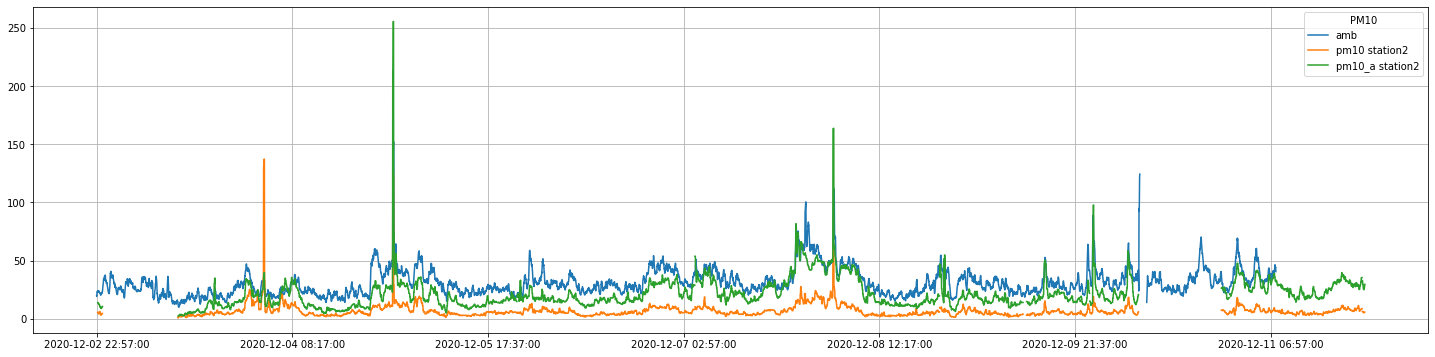

In [14]:
plt.figure(figsize=(25,6))
all_stations["PM10"].plot(label="amb")
all_stations["pm10_"+station].plot(label="pm10 station"+station)
all_stations["pm10_a"+station].plot(label="pm10_a station"+station)
#plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.savefig('pm10_several_'+name+'.png',bbox_inches='tight')
plt.show()

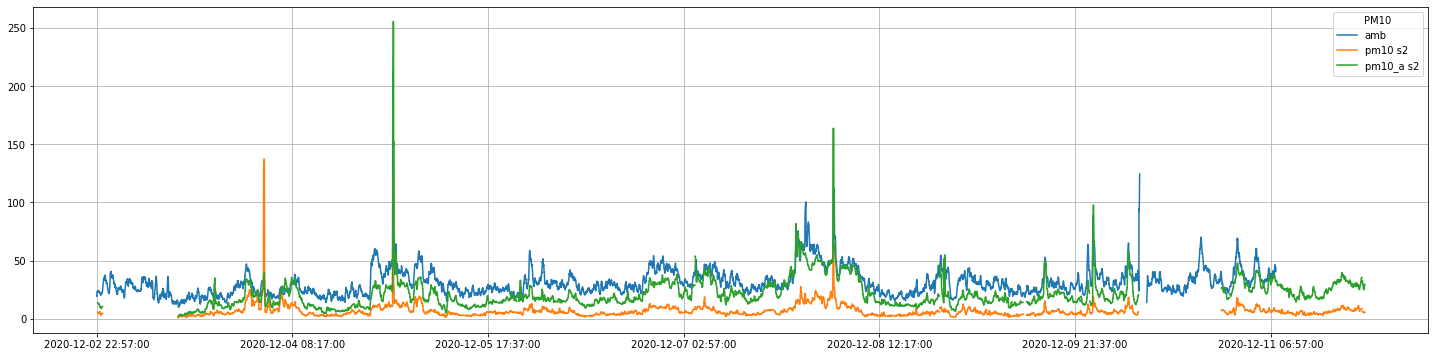

In [15]:
plt.figure(figsize=(25,6))
all_stations["PM10"].plot(label="amb")
all_stations["pm10_2"].plot(label="pm10 s2")
all_stations["pm10_a2"].plot(label="pm10_a s2")
#plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.show()

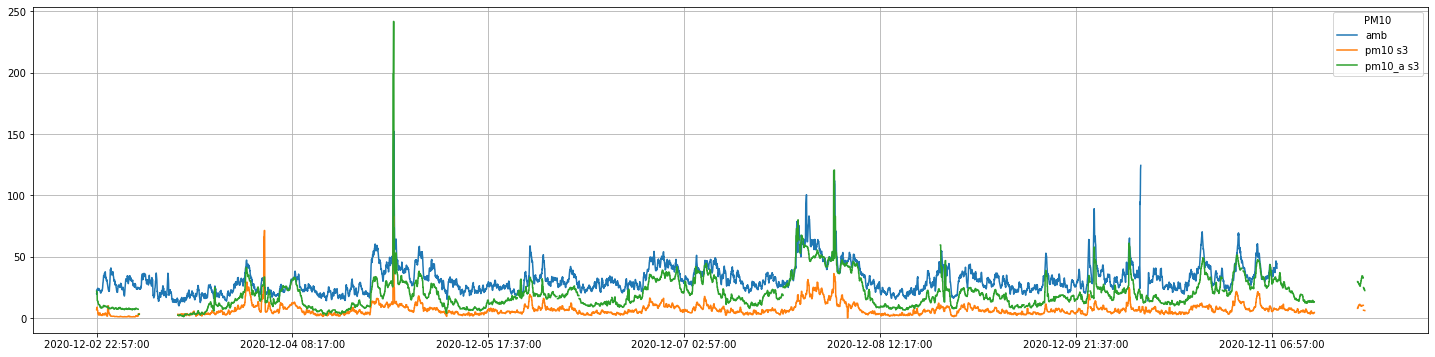

In [16]:
plt.figure(figsize=(25,6))
all_stations["PM10"].plot(label="amb")
all_stations["pm10_3"].plot(label="pm10 s3")
all_stations["pm10_a3"].plot(label="pm10_a s3")
#plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.show()

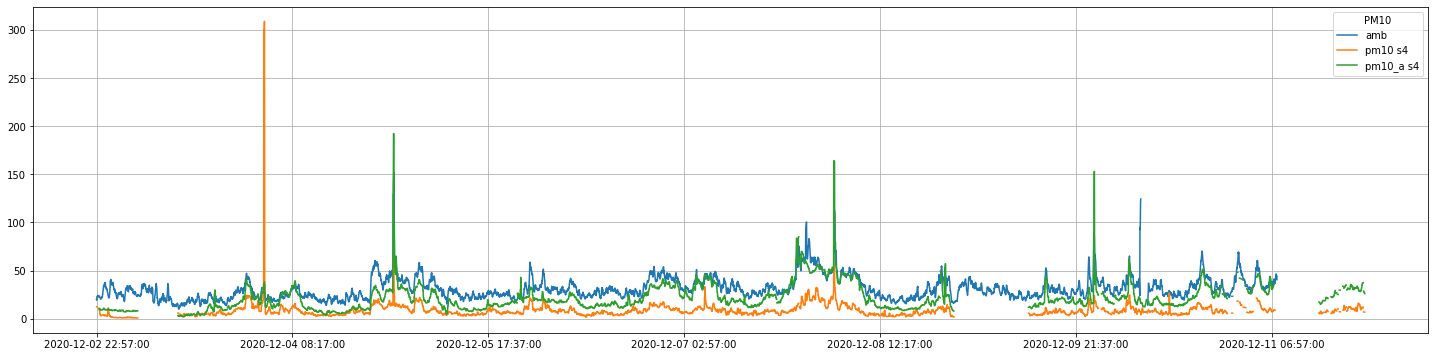

In [17]:
plt.figure(figsize=(25,6))
all_stations["PM10"].plot(label="amb")
all_stations["pm10_4"].plot(label="pm10 s4")
all_stations["pm10_a4"].plot(label="pm10_a s4")
#plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.show()

In [18]:
all_stations=cutdata(all_stations)
all_stations=all_stations.dropna()
all_stations

,Temp_interna,Temp_Aire,Lluvia,Humedad_Relativa,WD,WS,R_Solar,PM10,PM2.5,NOx,...,t_2,p_2,h_2,pm10_1,pm10_a1,pm25_1,pm25_a1,t_1,p_1,h_1
2020-12-03 12:50:00,22.8,27.3,0.0,57.3,333.7,3.2,314.7,12.2,4.7,5.7,...,31.610001,908.092651,51.812500,3.277817,1.250000,0.701332,1.250000,29.379999,906.789062,57.876953
2020-12-03 12:51:00,22.8,27.0,0.0,59.0,332.9,3.6,297.8,11.6,4.7,5.3,...,31.610001,908.092651,51.812500,3.277817,1.250000,0.701332,1.250000,29.379999,906.789062,57.876953
2020-12-03 12:52:00,22.8,26.6,0.0,60.5,337.6,3.7,289.2,11.1,4.7,4.8,...,31.610001,908.092651,51.812500,3.277817,1.250000,0.701332,1.250000,29.379999,906.789062,57.876953
2020-12-03 12:53:00,22.8,26.4,0.0,61.7,312.6,3.0,289.7,10.6,4.7,4.9,...,31.610001,908.092651,51.812500,3.277817,1.250000,0.701332,1.250000,29.379999,906.789062,57.876953
2020-12-03 12:54:00,22.8,26.2,0.0,60.3,314.2,2.7,296.7,10.5,4.7,4.9,...,31.825001,908.066742,50.665039,3.277817,1.250000,0.701332,1.250000,29.379999,906.789062,57.876953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04 10:03:00,22.7,28.3,0.0,48.9,349.1,1.2,690.0,22.1,12.0,7.7,...,35.165001,910.065002,38.497070,5.149142,9.916667,3.008138,9.333334,32.960001,908.959076,42.965820
2020-12-04 10:04:00,22.7,28.4,0.0,48.6,344.9,0.9,691.2,21.3,12.0,7.6,...,35.165001,910.065002,38.497070,4.762944,9.916667,2.505622,9.333334,32.740002,908.947266,43.303711
2020-12-04 10:05:00,22.7,28.5,0.0,47.9,309.0,1.1,697.3,22.4,12.1,7.7,...,35.165001,910.065002,38.497070,4.762944,9.916667,2.505622,9.333334,32.460001,908.917786,44.340820
2020-12-04 10:06:00,22.7,28.5,0.0,47.5,295.4,1.0,694.0,23.1,12.1,7.6,...,35.165001,910.065002,38.497070,4.762944,9.916667,2.505622,9.333334,32.460001,908.917786,44.340820


## Trying fit a simple model for data calibration

In [19]:
X = pd.DataFrame(all_stations["pm10_"+station])
Y = all_stations["PM10"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=9)
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)
pred = lin_reg_mod.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

In [20]:
print('RMSE =', test_set_rmse)
print("COEF =", lin_reg_mod.coef_)
print("Intercept =", lin_reg_mod.intercept_)

RMSE = 6.382369775937439
COEF = [0.2256232]
Intercept = 21.20210252184916


No handles with labels found to put in legend.


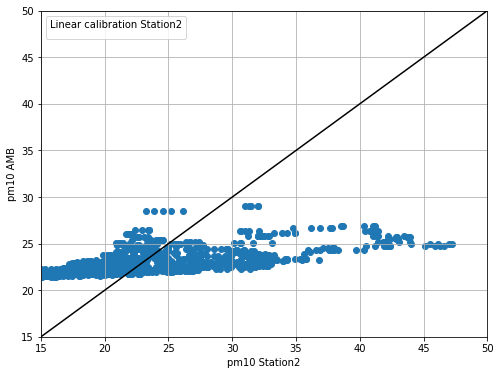

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(all_stations["PM10"],all_stations["pm10_"+station]*lin_reg_mod.coef_[0]+lin_reg_mod.intercept_)
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylim(15,50)
plt.xlim(15,50)
plt.xlabel("pm10 "+name)
plt.ylabel("pm10 AMB")
plt.grid()
plt.legend(title="Linear calibration "+name)
plt.savefig('pm10_linear_'+name+'.png',bbox_inches='tight')
plt.show()

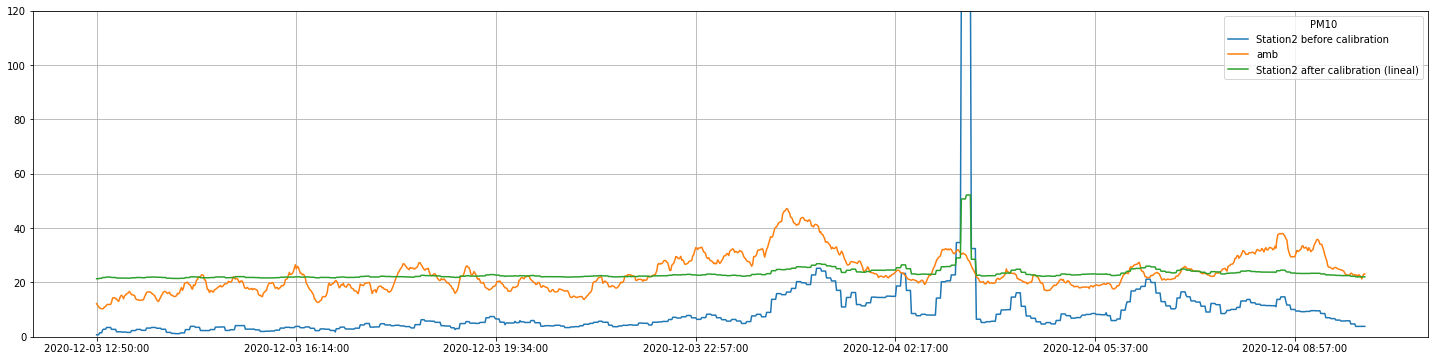

In [22]:
plt.figure(figsize=(25,6))
all_stations["pm10_"+station].plot(label=name+" before calibration")
all_stations["PM10"].plot(label="amb")
plt.plot(all_stations["pm10_"+station]*lin_reg_mod.coef_[0]+lin_reg_mod.intercept_,label=name+' after calibration (lineal)')
plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.show()

In [23]:
import statsmodels.api as sm

y = all_stations["PM10"]
X = all_stations["pm10_"+station]
X_c = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
# Note the difference in argument order
model = sm.OLS(y, X_c).fit()
predictions = model.predict(X_c) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PM10   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     192.2
Date:                Thu, 25 Mar 2021   Prob (F-statistic):           8.51e-41
Time:                        14:03:08   Log-Likelihood:                -4122.4
No. Observations:                1271   AIC:                             8249.
Df Residuals:                    1269   BIC:                             8259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6067      0.215    100.704      0.000      21.186      22.028
pm10_2         0.1926      0.014     13.863      0.000       0.165       0.220
==============================================================================
Omnibus:                      143.451   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.492
Skew:                           0.807   Prob(JB):                     9.76e-48
Kurtosis:                       4.218   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Trying fit a multiple model for data calibration

In [24]:
X = pd.DataFrame(np.c_[all_stations["pm10_"+station], all_stations["t_"+station], all_stations["p_"+station], all_stations["h_"+station]], 
                 columns=["pm10_"+station,"t_"+station,"p_"+station,"h_"+station])
Y = all_stations["PM10"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=9)
lin_reg_mod2 = LinearRegression()
lin_reg_mod2.fit(X_train, y_train)
pred = lin_reg_mod2.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

In [25]:
print('RMSE =', test_set_rmse)
print("COEF =", lin_reg_mod2.coef_)
print("Intercept =", lin_reg_mod2.intercept_)

RMSE = 5.403794795039589
COEF = [0.18806847 2.23405004 2.26935672 0.68254907]
Intercept = -2146.4644821293155


No handles with labels found to put in legend.


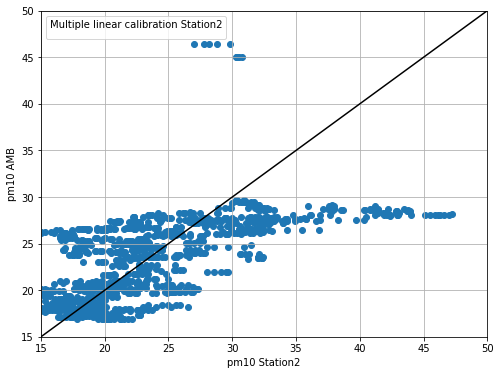

In [26]:
plt.figure(figsize=(8,6))
#comuneros["pm10"].plot(label="comuneros")
plt.scatter(all_stations["PM10"],all_stations["pm10_"+station]*lin_reg_mod2.coef_[0]+
            all_stations["t_"+station]*lin_reg_mod2.coef_[1]+
            all_stations["p_"+station]*lin_reg_mod2.coef_[2]+
            all_stations["h_"+station]*lin_reg_mod2.coef_[3]+
            lin_reg_mod2.intercept_)
#plt.scatter(all_stations["pm10"],all_stations["pm10"])
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylim(15,50)
plt.xlim(15,50)
plt.xlabel("pm10 "+name)
plt.ylabel("pm10 AMB")
plt.grid()
plt.legend(title="Multiple linear calibration "+name)
plt.savefig('pm10_multiple_'+name+'.png',bbox_inches='tight')
plt.show()

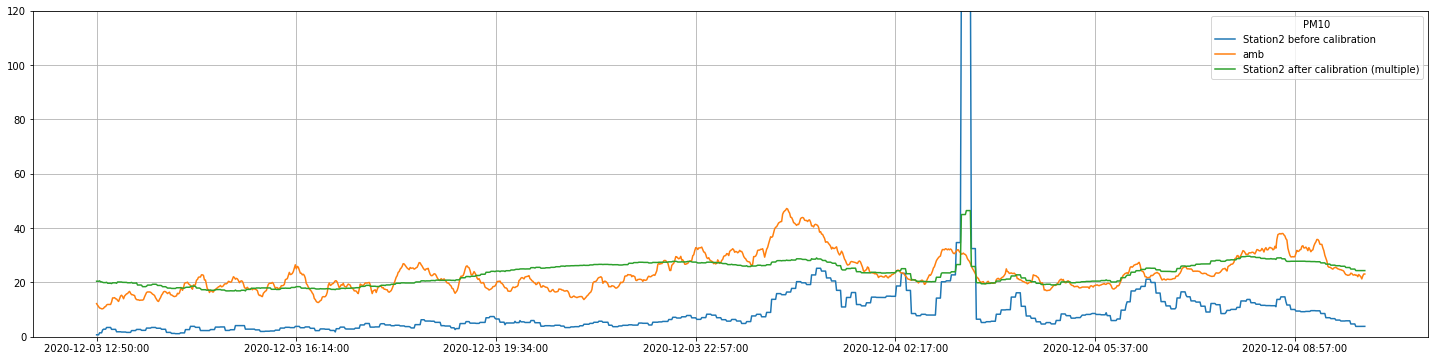

In [27]:
plt.figure(figsize=(25,6))
all_stations["pm10_"+station].plot(label=name+" before calibration")
all_stations["PM10"].plot(label="amb")
plt.plot(all_stations["pm10_"+station]*lin_reg_mod2.coef_[0]+
            all_stations["t_"+station]*lin_reg_mod2.coef_[1]+
            all_stations["p_"+station]*lin_reg_mod2.coef_[2]+
            all_stations["h_"+station]*lin_reg_mod2.coef_[3]+
            lin_reg_mod2.intercept_,label=name+' after calibration (multiple)')
plt.ylim(0,120)
plt.grid()
plt.legend(title="PM10")
plt.show()

## Desarrollando random forest para el conjunto de datos usando SKLearn (machine Learning)...

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.externals import joblib 
from sklearn.preprocessing import LabelEncoder 
from numpy.core.umath_tests import inner1d

<ipython-input-28-7f523acdadb5>:9: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [29]:
train_features,test_features,train_labels,test_labels=train_test_split(X,Y,test_size=0.5,random_state=0)
# Instantiate model with 1000 decision trees
rf=RandomForestRegressor(n_estimators=800,random_state=0)#,max_features="sqrt",criterion="mse"
# Train the model on training data
rf.fit(train_features,train_labels);
# Use the forest's predict method on the test data
predictions=rf.predict(test_features)
# Calculate the absolute errors
errors=abs(predictions-test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors))
# Calculate mean absolute percentage error (MAPE)
mape=100*abs(errors/test_labels)
rmse=np.sqrt(np.mean(errors**2))
# Calculate and display accuracy
accuracy=100-np.mean(mape)
print('Accuracy:', accuracy)
print('RMSE:', rmse)

Mean Absolute Error: 0.7573032884033676
Accuracy: 96.60632358509297
RMSE: 1.0914103576659757


No handles with labels found to put in legend.


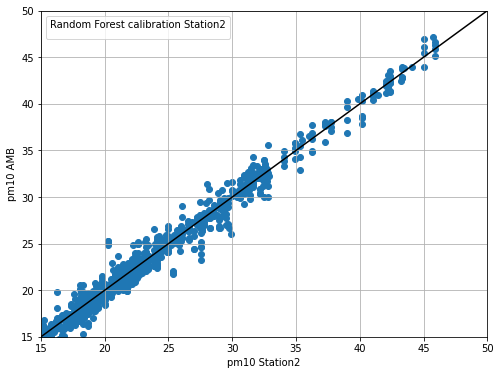

In [30]:
plt.figure(figsize=(8,6))
#axe=np.linspace(data[station].min()-0.2,data[station].max()+0.2,10)
plt.scatter(rf.predict(X),all_stations["PM10"],label='',lw=1,marker='o') 
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylabel("pm10 AMB")
plt.xlabel("pm10 "+name)
plt.ylim(15,50)
plt.xlim(15,50)
plt.grid()
plt.legend(title="Random Forest calibration "+name)
plt.savefig('pm10_rf_'+name+'.png',bbox_inches='tight')
plt.show()

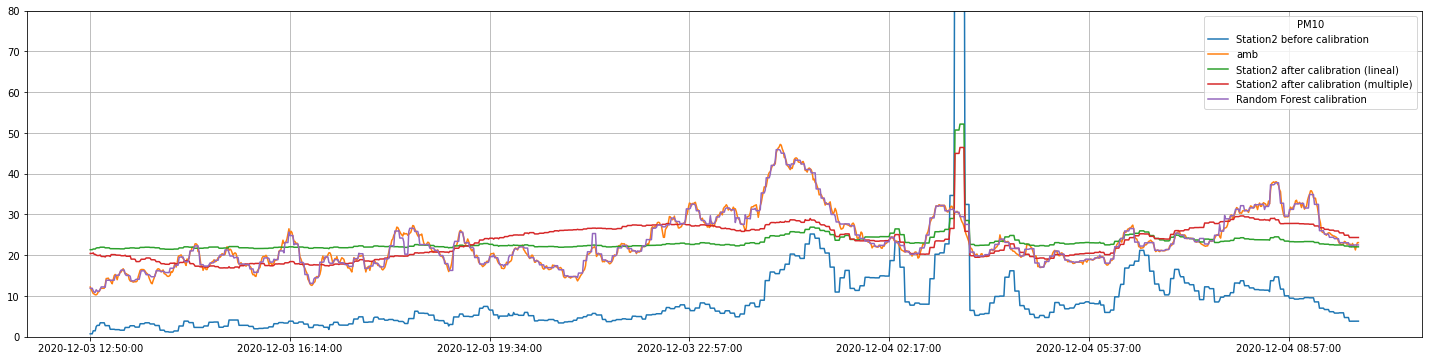

In [31]:
plt.figure(figsize=(25,6))
all_stations["pm10_"+station].plot(label=name+" before calibration")
all_stations["PM10"].plot(label="amb")
plt.plot(all_stations["pm10_"+station]*lin_reg_mod.coef_[0]+lin_reg_mod.intercept_,label=name+' after calibration (lineal)')
plt.plot(all_stations["pm10_"+station]*lin_reg_mod2.coef_[0]+
            all_stations["t_"+station]*lin_reg_mod2.coef_[1]+
            all_stations["p_"+station]*lin_reg_mod2.coef_[2]+
            all_stations["h_"+station]*lin_reg_mod2.coef_[3]+
            lin_reg_mod2.intercept_,label=name+' after calibration (multiple)')
plt.plot(rf.predict(X),label='Random Forest calibration')
plt.ylim(0,80)
plt.grid()
plt.legend(title="PM10")
plt.savefig('pm10_calibrations_'+name+'.png',bbox_inches='tight')
plt.show()